In [1]:
import pandas as pd
import numpy as np
from graph_data import GraphData
from IPython.display import display

from vega import VegaLite
from vega import utils

# import matplotlib.pyplot as plt 


In [2]:

# path = "../../../vast/MC1/data/"
path = "../../data/"

nodes_file_template = "CGCS-Template-NodeTypes.csv"
edges_file_template = "CGCS-Template"

graphs={}

graph = GraphData()
graph.read_data(nodes_file=nodes_file_template, edges_file=edges_file_template+".csv", path=path)
graph.edges['EndTime'] = graph.edges.apply(
    lambda row: row['Time'] + pd.Timedelta(days=row['Weight']) 
    if row['eType'] == 'Travels-to' else None , axis=1)

                                           
graphs[edges_file_template] = graph


stList = graph.edges.stType.unique()

nodes_file = "CGCS-GraphData-NodeTypes.csv"
graph_names = ["Q1-Graph1", "Q1-Graph2", "Q1-Graph3", "Q1-Graph4", "Q1-Graph5"]

offsets = {
     1: -0.8666666666666667,
     3: -7.4,
     4: -11.0,
     2: 6.066666666666666,
     0: -2.7333333333333334,
     5: 10.4
}

apply_offsets_target = lambda  tl, tt: tt - pd.Timedelta(hours=offsets[tl]) 

for name in graph_names:
    graph = GraphData()
    graph.read_data(nodes_file=nodes_file, edges_file=name+".csv", path=path, stList=stList)
    graph.edges['Time'] = graph.edges.apply(
        lambda row: row['Time'] - pd.Timedelta(hours=offsets[row['SourceLocation']]) 
        if row['eType'] == 'Travels-to' else row['Time'],
        axis=1)
    
    graph.edges['EndTime'] = graph.edges.apply(
        lambda row:  row['Time'] +  pd.Timedelta(days=(row['Weight']))
#                                                  + offsets[row['SourceLocation']] - offsets[row['TargetLocation']])
        if row['eType'] == 'Travels-to' else None,
        axis=1)
#     graph.edges['EndTime'] = graph.edges.apply(lambda row: row['Time'] + pd.Timedelta(days=row['Weight']) if row['eType'] == 'Travels-to' else None , axis=1)
    graphs[name] = graph
                                                                         

FileNotFoundError: [Errno 2] File ./CGCS-Template-NodeTypes.csv does not exist: './CGCS-Template-NodeTypes.csv'

In [4]:
locations_all = {}

for name, graph in graphs.items():
    locations = {}
    for index, row in graph.edges_no_financial.iterrows():
        if row.eType == 'Phone':
            locations[row.Source] = row.SourceLocation
            locations[row.Target] = row.TargetLocation
            
    locations_all[name] = locations

In [5]:
def chart_target_location(data_travels, data_locations, domain_locations, field="Source", title=''):
    return VegaLite({
        "title": {
            "text": f'Travels {title}',
            "fontWeight":200
        },
        "spacing": 0,
        "padding": 0,
        "bounds": "flush",
        "hconcat": [{
            "height": {'step': 15},
            "data": {'values': data_locations},
                "mark":{
                    "type":"circle",
                },
             "encoding":{
                 "y":{
                    "field": "Source",
                    "type":"ordinal",
                     "axis":{
                     "titleFontWeight": 300,
                     "offset": -5,
                    "ticks": False,
                    "domain": False,
                    "title": "Source", 
                    "labels": True,
                    "labelFontSize": 9,
                    "orient": "left",}
                 },
                 "color": {
                        "field": "Location",
                        "type": "nominal",
                        "scale": {
                            "domain": domain_locations,
                        },
                        "legend": True
                    },
             }
        },{
            "width": 800,
            "bounds": "flush",
            "height": {'step': 15},
            "data": {'values': data_travels},
            "transform": [{"calculate": "random()", "as": "jitter"}],
            "encoding":{
                    "x":{
                        "field":"Time",
                        "type":"temporal",
                        "axis": {
                            "grid": False
                        }   ,
                        "scale": {
                            "domain": [{"year": 2025, "month": 1}, {"year": 2026, "month": 1}]
                        }
                    },
                 
                    "y":{
                        "field": field,
                        "type":"ordinal",
                        "axis":{
                            "title": None, 
                            "ticks": False,
                            "offset": 5,
                            "domain": False,
                            "grid": True,
                            "gridDash": {
                                "value": [2,2]
                            }, 
                            "labels": False,
                            "labelFontSize": 9,
                            "orient": "left",
                            "titleFontWeight": 300
                        },
                        "sort": {
                            "field": "Source"
                        }
                    },
                   
            },
                "layer":[{
                
                "mark":{
                    "type":"bar",
                    "height": 6,
                    "opacity": 0.7,
                    "stroke": 'grey'
                },
                "encoding":{
                    "x2":{
                        "field":"EndTime",
                        "type":"temporal",
                    },
                    "color": {
                        "field": "TargetLocation",
                        "type": "nominal",
                        "scale": {
                            "domain": domain_locations,
                        },
                        "legend": False
                    },
                    "tooltip": {
                        "field": "SourceLocation",
                        "type": "nominal"
                    }
                }, 
            },{
                   "mark":{
                    "type":"circle",
                    "size": 12,
                   "stroke": 'grey',
                   "strokeWidth": 0.5,
                   "opacity": 1,

                       "zindex": 3

                   },
                       "encoding":{
                           
                       "color": {
                           "field": "SourceLocation",
                           "type": "nominal",
                           "scale": {
                            "domain": domain_locations,
                        }, 
                   } 
                   
                }
            }]
        }],
        "config": {
                "style": {
                    "cell": {
                        "stroke": "transparent"
                    },
                },
                "autosize": "pad",
                "padding": 0
            }
    })

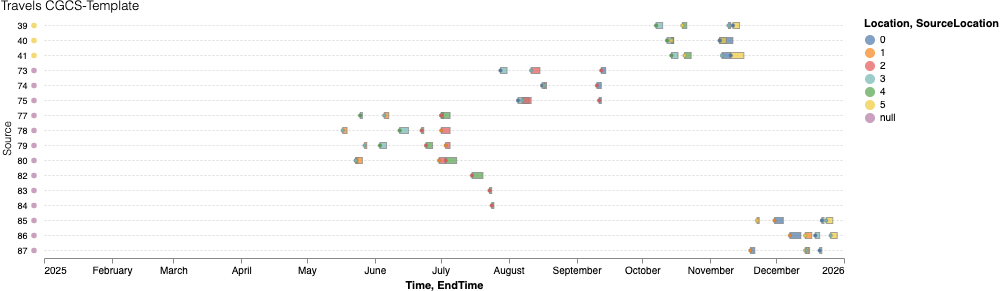

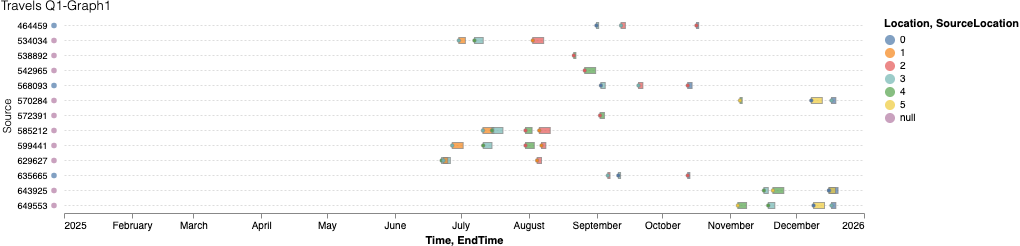

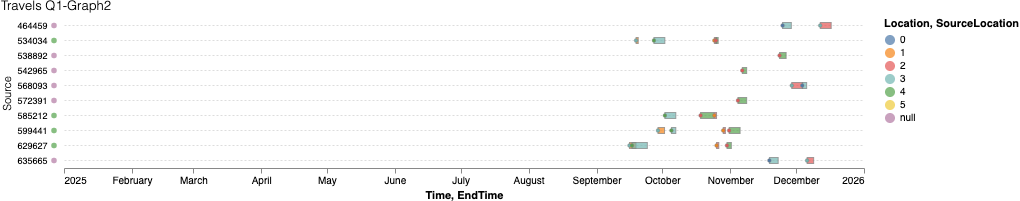

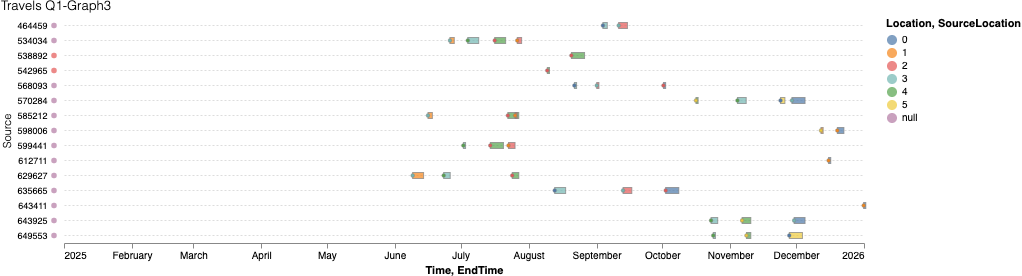

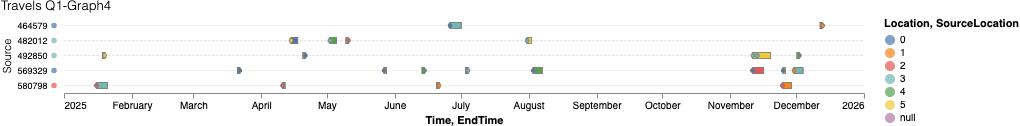

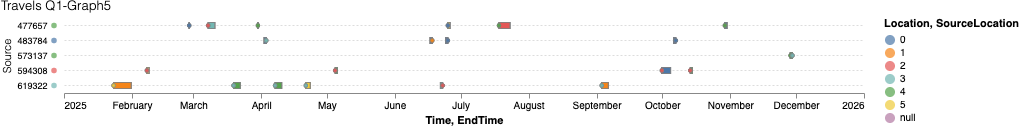

In [6]:
graph_name = "CGCS-Template"

for graph_name in graphs.keys():
#     graphs[graph_name].edges['EndTime'] = graphs[graph_name].edges.apply(lambda row: row['Time'] + pd.Timedelta(days=row['Weight']) if row['eType'] == 'Travels-to' else None , axis=1)

    mask =  graphs[graph_name].edges.eType=='Travels-to'

    sources_with_travel = np.sort(pd.unique(graphs[graph_name].edges[mask].Source))
    dict_locations = {}
    list_locations = []
    for s in sources_with_travel:
        dict_locations[s] = locations_all[graph_name][s] if s in locations_all[graph_name] else None
        list_locations.append({'Source': s, 'Location': dict_locations[s]})


    data_travels = utils.sanitize_dataframe(graphs[graph_name].edges[mask]).to_dict(orient='records')

    display(chart_target_location(data_travels, list_locations, list(range(6)) + [None], "Source", graph_name))

### 

In [ ]:
graph = graphs[graph_names[1]]

from timezonefinder import TimezoneFinder

my_func = TimezoneFinder().closest_timezone_at  #Note the no parenthesis on the function call!
graph.edges['TargetTZ'] = graph.edges.apply(lambda row: my_func(lng=row.TargetLongitude, lat=row.TargetLatitude) 
                                            if not np.isnan(row.TargetLongitude) else None  , axis=1)
graph.edges['SourceTZ'] = graph.edges.apply(lambda row: my_func(lng=row.SourceLongitude, lat=row.SourceLatitude)
                                            if not np.isnan(row.SourceLongitude) else None  , axis=1)


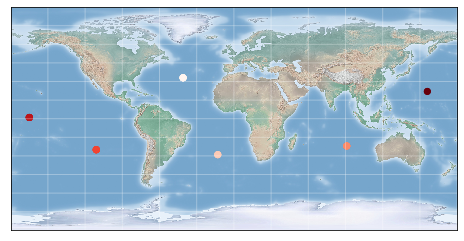

In [51]:
import os
os.environ['PROJ_LIB'] = r'/Users/paola/miniconda/share/proj/'

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')
 

graph = graphs[graph_names[2]]
mask = graph.edges.eType=='Travels-to'

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

m.scatter(graph.edges[mask].TargetLongitude, graph.edges[mask].TargetLatitude, 
          latlon=True,
          c=graph.edges[mask].Target,
          cmap='Reds', alpha=1)

In [67]:
offset = lambda longitude: longitude * 24 / 360
offsets = dict(zip(pd.unique(graph.edges.Target[(graph.edges.eType=='Travels-to')]),offset(pd.unique(graph.edges.TargetLongitude[(graph.edges.eType=='Travels-to')]))))

In [ ]:
# Proof that phone locations are unique
for name, graph in graphs.items():
    locations = {}
    for index, row in graph.edges_no_financial.iterrows():
        if row.eType == 'Phone':
            if row.Source not in locations:
                locations[row.Source] = set()
            if row.Target not in locations:
                locations[row.Target] = set()
            locations[row.Source].add(row.SourceLocation)
            locations[row.Target].add(row.TargetLocation)
       
#     for s, l in locations.items():
#         print(len(l))

In [ ]:
def chart_target_location(df_node_tl, tl, sc_types, field="Source"):
    return VegaLite({
        "title": {
            "text": f'location {tl}',
            "fontWeight":200
        },
        "width": 800,
        "heigh": {"step": 3},
        "bounds": "flush",
#         "height": 300,
        "height": {'step': 7},
        
            "mark":{
                "type":"circle",
            },
            "encoding":{
                "x":{
                    "field":"Time",
                    "type":"temporal",
                    "axis": {
                        "grid": False
                    }   ,
                    "scale": {
                        "domain": [{"year": 2025, "month": 1}, {"year": 2026, "month": 1}]
                    }
                },
                "y":{
                    "field": field,
                    "type":"ordinal",
                    "axis":{
#                         "title": title, 
                        "ticks": False,
                        "offset": 5,
                        "domain": False,
                        "grid": True,
                        "gridDash": {
                            "value": [2,2]
                        },  
                        "labelFontSize": 7,
                        "orient": "left",
                        "titleFontWeight": 300
                    },
                    "sort": {
                        "field": "eType"
                    }
                },
                "color": {
                    "field": "eType",
                    "type": "nominal",
                    "scale": {
                        "domain": sc_types,
                    },
#                     "legend": legend
                },
                "tooltip": {
                    "field": "Time",
                    "type": "temporal"
                }
            },
        "config": {
            "style": {
                "cell": {
                    "stroke": "transparent"
                },
            },
            "autosize": "pad",
            "padding": 0
        }
    }, df_node_tl)

In [ ]:
sc_types = ['Email', 'Phone', 'Buy', 'Sell', 'Travels-to']


In [ ]:

graph_name = "CGCS-Template"


mask =  graphs[graph_name].edges_no_financial.eType!='Author-of'

group_by_target_location = graphs[graph_name].edges_no_financial[mask].groupby('TargetLocation')

groups_tl = group_by_target_location.groups.keys()
    
for t_id in groups_tl:
    df_node_tl = group_by_target_location.get_group(t_id)
    display(chart_target_location(df_node_tl, t_id, sc_types, "Source"))